In [ ]:
import pandas as pd

# Charger les articles
articles = pd.read_json("C:/Users/GENIUS ELECTRONICS/Desktop/Detec-Biais-nlp/data/Processed/polarite_cameroun_rss.json")

# Charger le lexique
lexique = pd.read_csv("C:/Users/GENIUS ELECTRONICS/Desktop/Detec-Biais-nlp/data/lexique_emotionnel.csv", encoding="utf-8")
lexique['mot'] = lexique['mot'].str.lower()

# Dictionnaires pour recherche rapide
pol_dict = dict(zip(lexique['mot'], lexique['polarit√©']))
emo_dict = dict(zip(lexique['mot'], lexique['√©motion']))


In [100]:
from collections import defaultdict, Counter

# Regrouper tous les tokens par m√©dia (ind√©pendamment du th√®me ici)
tokens_par_media = defaultdict(list)

for _, row in articles.iterrows():
    media = row.get("Nom du m√©dia", "Inconnu")
    tokens = row.get("tokens_Texte", [])
    if isinstance(tokens, str):
        try:
            tokens = eval(tokens)
        except:
            tokens = []
    tokens = [t.lower() for t in tokens if isinstance(t, str) and len(t) > 2]
    tokens_par_media[media].extend(tokens)
# Compter tous les tokens pour trouver les plus fr√©quents
global_freq = Counter()

for tokens in tokens_par_media.values():
    global_freq.update(tokens)

# Choisir les 30 tokens les plus fr√©quents (modifiable)
top_tokens = [t for t, _ in global_freq.most_common(30)]


In [ ]:
import pandas as pd

# Initialiser DataFrame
matrix = pd.DataFrame(index=tokens_par_media.keys(), columns=top_tokens).fillna(0)

# Remplir les fr√©quences
for media, tokens in tokens_par_media.items():
    token_counts = Counter(tokens)
    for token in top_tokens:
        matrix.loc[media, token] = token_counts.get(token, 0)


C:\Users\GENIUS ELECTRONICS\AppData\Local\Temp\ipykernel_7220\2102101308.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix_log = matrix.applymap(lambda x: np.log1p(x))


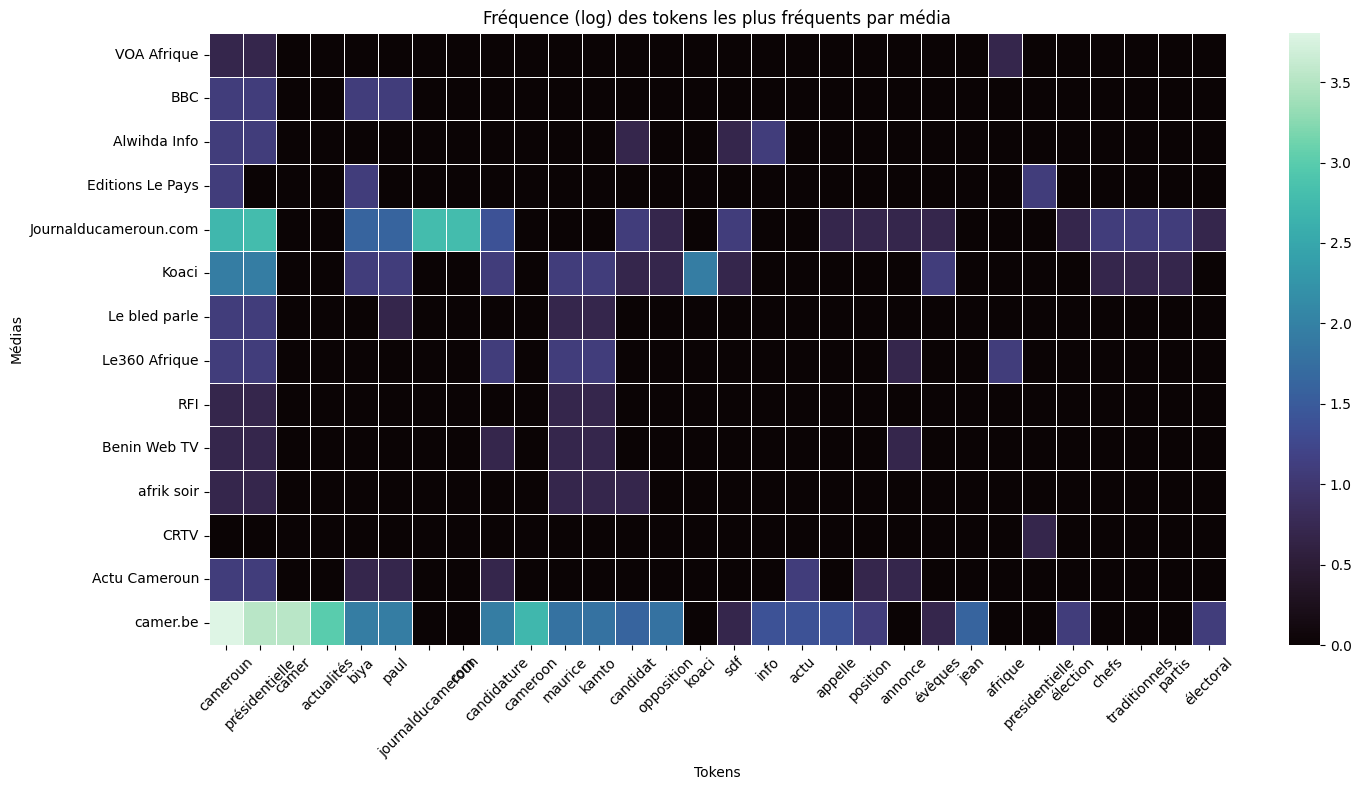

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Appliquer log(1 + x) pour adoucir les grandes valeurs
matrix_log = matrix.applymap(lambda x: np.log1p(x))

plt.figure(figsize=(15, 8))
sns.heatmap(matrix_log, cmap="mako", annot=False, linewidths=0.5)

plt.title("Fr√©quence (log) des tokens les plus fr√©quents par m√©dia")
plt.xlabel("Tokens")
plt.ylabel("M√©dias")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
# Nettoyer les tokens et reformer le corpus
def clean_tokens(x):
    if isinstance(x, str):
        try:
            tokens = eval(x)
        except:
            return ""
    elif isinstance(x, list):
        tokens = x
    else:
        return ""
    
    tokens = [t for t in tokens if isinstance(t, str) and len(t) > 2]
    return " ".join(tokens)

corpus_textes = articles["tokens_Texte"].apply(clean_tokens)

# Optionnel : retirer les lignes vides
corpus_textes = corpus_textes[corpus_textes.str.strip().astype(bool)]


In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2)  # pas de stop_words
X = vectorizer.fit_transform(corpus_textes)


In [65]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
def afficher_themes(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\n Th√®me {idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

afficher_themes(lda, vectorizer.get_feature_names_out())
articles["topic_lda"] = lda.transform(X).argmax(axis=1)





 Th√®me 0:
kamto maurice candidature afrique annonce fonds collecte opposant bled parle

 Th√®me 1:
presidentielle cameroon camer biya √©ric chinje pr√©s radical gouvernance √¢ge

 Th√®me 2:
camer actualit√©s sdf koaci opposition candidat grand nord cameroon position

 Th√®me 3:
journalducameroun com paul biya candidature partis chefs traditionnels √©v√™ques politiques

 Th√®me 4:
camer actualit√©s cameroon paul biya maurice kamto jean candidature opposition


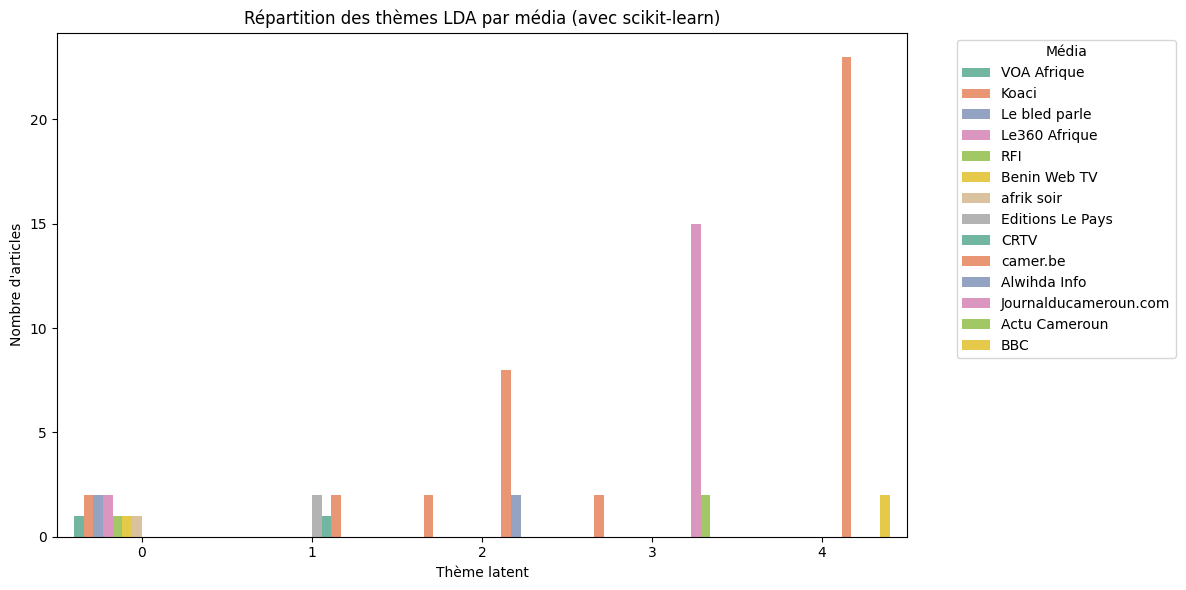

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=articles, x="topic_lda", hue="Nom du m√©dia", palette="Set2")
plt.title("R√©partition des th√®mes LDA par m√©dia (avec scikit-learn)")
plt.xlabel("Th√®me latent")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=0)
plt.legend(title="M√©dia", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [104]:
def afficher_themes(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTh√®me {idx} :")
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("Mots-cl√©s :", ", ".join(top_words))

afficher_themes(lda, vectorizer.get_feature_names_out())



Th√®me 0 :
Mots-cl√©s : kamto, maurice, candidature, afrique, annonce, fonds, collecte, opposant, bled, parle

Th√®me 1 :
Mots-cl√©s : presidentielle, cameroon, camer, biya, √©ric, chinje, pr√©s, radical, gouvernance, √¢ge

Th√®me 2 :
Mots-cl√©s : camer, actualit√©s, sdf, koaci, opposition, candidat, grand, nord, cameroon, position

Th√®me 3 :
Mots-cl√©s : journalducameroun, com, paul, biya, candidature, partis, chefs, traditionnels, √©v√™ques, politiques

Th√®me 4 :
Mots-cl√©s : camer, actualit√©s, cameroon, paul, biya, maurice, kamto, jean, candidature, opposition


In [ ]:
theme_labels = {
    0: "Opposition & d√©mocratie",
    1: "√âlections locales",
    2: "Gouvernement & administration",
    3: "√âglise et soci√©t√©",
    4: "Campagne pr√©sidentielle"
}

# Appliquer le label dans le DataFrame
articles["theme_label"] = articles["topic_lda"].map(theme_labels)
# Compter combien d‚Äôarticles chaque m√©dia consacre √† chaque th√®me
table = pd.crosstab(articles["Nom du m√©dia"], articles["topic_lda"])
# M√©dias qui n'ont rien publi√© sur un th√®me
omissions = {}

for media in table.index:
    themes_omits = table.columns[table.loc[media] == 0].tolist()
    if themes_omits:
        omissions[media] = themes_omits
print("M√©dias n'ayant couvert aucun article sur certains th√®mes :")

for media, themes in omissions.items():
    noms_themes = [theme_labels.get(t, f"Th√®me {t}") for t in themes]
    print(f"\n {media} omet : {', '.join(noms_themes)}")




üéØ M√©dias n'ayant couvert aucun article sur certains th√®mes :

 Actu Cameroun omet : Opposition & d√©mocratie, √âlections locales, Gouvernement & administration, Campagne pr√©sidentielle

 Alwihda Info omet : Opposition & d√©mocratie, √âlections locales, √âglise et soci√©t√©, Campagne pr√©sidentielle

 BBC omet : Opposition & d√©mocratie, √âlections locales, Gouvernement & administration, √âglise et soci√©t√©

 Benin Web TV omet : √âlections locales, Gouvernement & administration, √âglise et soci√©t√©, Campagne pr√©sidentielle

 CRTV omet : Opposition & d√©mocratie, Gouvernement & administration, √âglise et soci√©t√©, Campagne pr√©sidentielle

 Editions Le Pays omet : Opposition & d√©mocratie, Gouvernement & administration, √âglise et soci√©t√©, Campagne pr√©sidentielle

 Journalducameroun.com omet : Opposition & d√©mocratie, √âlections locales, Gouvernement & administration, Campagne pr√©sidentielle

 Koaci omet : √âlections locales, Campagne pr√©sidentielle

 Le bled parle omet :

In [84]:
# Matrice binaire : 1 = le m√©dia a au moins 1 article sur ce th√®me, 0 = omission
binary_coverage = table.copy()
binary_coverage[binary_coverage > 0] = 1
# Bien reformuler les noms de colonnes
binary_coverage.columns = [theme_labels.get(int(i), f"Th√®me {int(i)}") for i in binary_coverage.columns]



C:\Users\GENIUS ELECTRONICS\AppData\Local\Temp\ipykernel_7220\620558371.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\GENIUS ELECTRONICS\anaconda3\envs\detection_biais\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


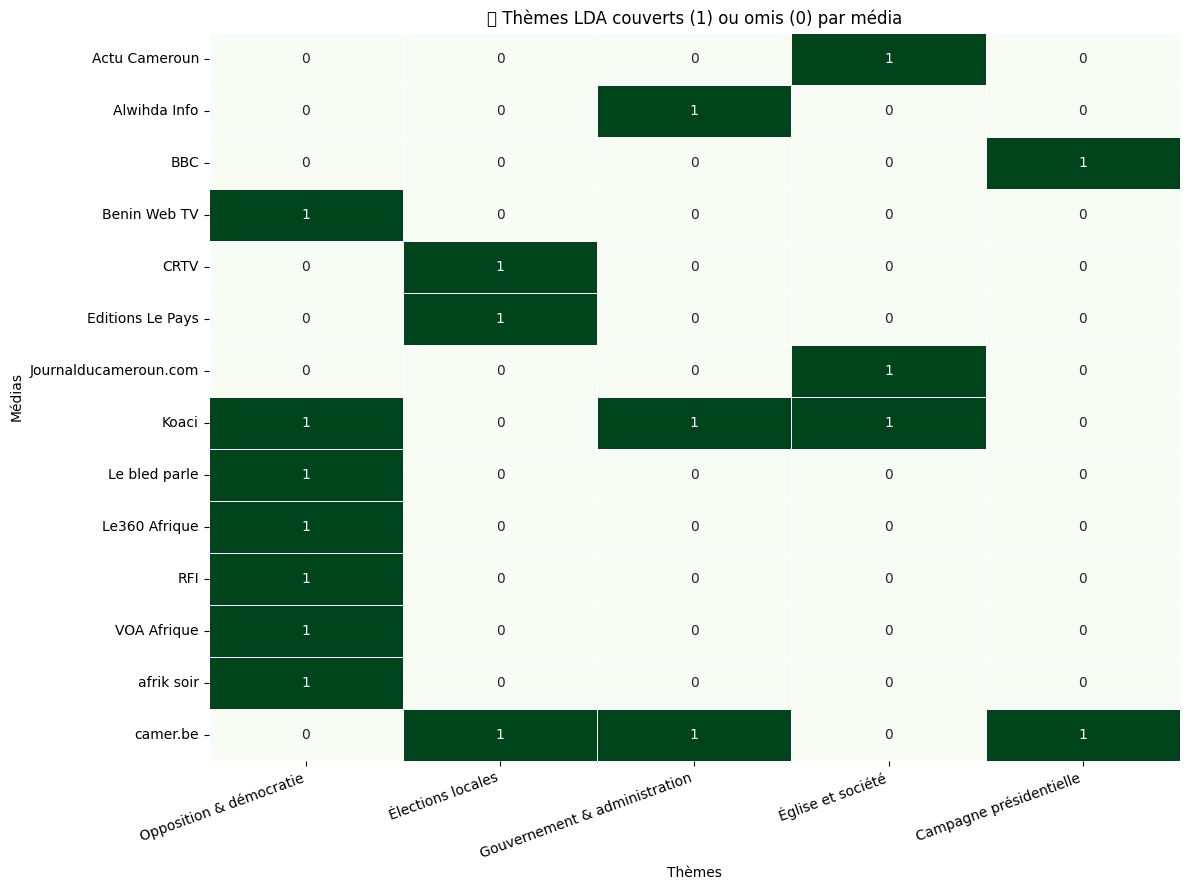

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
sns.heatmap(binary_coverage, cmap="Greens", linewidths=0.5, annot=True, cbar=False)

plt.title("Th√®mes LDA couverts (1) ou omis (0) par m√©dia")
plt.xlabel("Th√®mes")
plt.ylabel("M√©dias")
plt.xticks(rotation=20, ha="right")  # inclinaison propre
plt.tight_layout()
plt.show()

